# CODE LOAD MÔ HÌNH PYTORCH PTH

Inspecting depth model file structure...
Type of loaded file: <class 'dict'>
Keys in the dictionary: dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'scheduler_state_dict', 'train_loss', 'val_loss'])
✅ Depth model loaded successfully
Depth prediction successful

0: 480x640 1 backpack, 1 bed, 26.9ms
Speed: 1.3ms preprocess, 26.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)
Result saved to test2_depth_detection.png


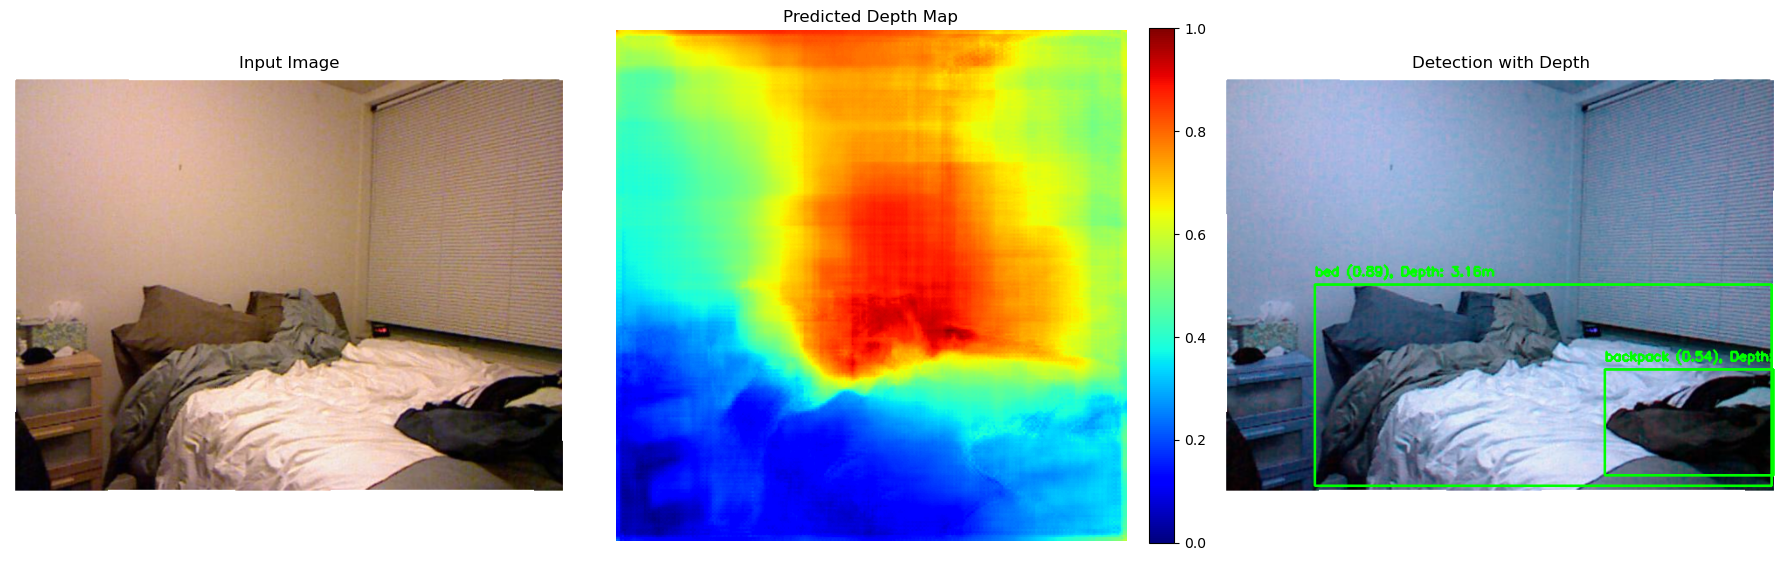

Processing complete. Result saved to test2_depth_detection.png


In [ ]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

import os
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from ultralytics import YOLO
from PIL import Image
import torch.nn as nn

from collections import OrderedDict

class ConvBlock(nn.Sequential):
    def __init__(self, in_c, out_c):
        super().__init__(OrderedDict([
            ('conv',       nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)),
            ('batch_norm', nn.BatchNorm2d(out_c)),
            ('activation', nn.LeakyReLU(0.2, inplace=True)),
        ]))

# -------------------------------------------------------------------
# 2) Định nghĩa đúng UNet giống state_dict bạn train
# -------------------------------------------------------------------

class DepthEstimationModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.conv1 = nn.Sequential(ConvBlock(3, 64),   ConvBlock(64, 64))
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Sequential(ConvBlock(64, 128), ConvBlock(128, 128))
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Sequential(ConvBlock(128, 256),ConvBlock(256, 256))
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = nn.Sequential(ConvBlock(256, 512),ConvBlock(512, 512), nn.Dropout(0.5))
        self.pool4 = nn.MaxPool2d(2)

        # Bridge
        self.bridge = nn.Sequential(
            ConvBlock(512, 1024),
            ConvBlock(1024, 1024),
            nn.Dropout(0.5)
        )

        # Decoder
        self.upconv6 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.conv6   = nn.Sequential(ConvBlock(512+512, 512), ConvBlock(512, 512))
        self.upconv7 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv7   = nn.Sequential(ConvBlock(256+256, 256), ConvBlock(256, 256))
        self.upconv8 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv8   = nn.Sequential(ConvBlock(128+128, 128), ConvBlock(128, 128))
        self.upconv9 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv9   = nn.Sequential(ConvBlock(64+64, 64),   ConvBlock(64, 64))

        # Output
        self.output  = nn.Conv2d(64, 1, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        c1 = self.conv1(x); p1 = self.pool1(c1)
        c2 = self.conv2(p1); p2 = self.pool2(c2)
        c3 = self.conv3(p2); p3 = self.pool3(c3)
        c4 = self.conv4(p3); p4 = self.pool4(c4)

        b  = self.bridge(p4)

        u6 = self.upconv6(b)
        m6 = torch.cat([c4, u6], dim=1)
        c6 = self.conv6(m6)

        u7 = self.upconv7(c6)
        m7 = torch.cat([c3, u7], dim=1)
        c7 = self.conv7(m7)

        u8 = self.upconv8(c7)
        m8 = torch.cat([c2, u8], dim=1)
        c8 = self.conv8(m8)

        u9 = self.upconv9(c8)
        m9 = torch.cat([c1, u9], dim=1)
        c9 = self.conv9(m9)

        out = self.output(c9)
        return self.sigmoid(out)

# -------------------------------------------------------------------
# 3) Hàm load model
# -------------------------------------------------------------------

def load_depth_model(path, device=None, strict=True, strip_dp=True):

    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    ckpt = torch.load(path, map_location=device)

    if isinstance(ckpt, dict) and 'model_state_dict' in ckpt:
        state_dict = ckpt['model_state_dict']
    else:
        state_dict = ckpt 


    if strip_dp:
        new_sd = OrderedDict()
        for k, v in state_dict.items():
            new_k = k.replace('module.', '')
            new_sd[new_k] = v
        state_dict = new_sd

    model = DepthEstimationModel().to(device)

    missing, unexpected = model.load_state_dict(state_dict, strict=strict)
    if missing:
        print("⚠️  Missing keys:", missing)
    if unexpected:
        print("⚠️  Unexpected keys:", unexpected)

    model.eval()
    print("✅ Depth model loaded successfully")
    return model


def load_models(depth_model_path="model_depth_prediction.pth", yolo_weights="yolov9e.pt"):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    depth_model = load_depth_model(depth_model_path, device, strict=False)  
    yolo_model  = YOLO(yolo_weights)

    return depth_model, yolo_model

def preprocess_image(image_path, target_size=(256, 256)):

    if isinstance(image_path, str):
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        img = image_path
        if len(img.shape) == 3 and img.shape[2] == 3:
            if img.dtype == np.uint8:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    original_size = img.shape[:2]
    
    img_resized = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
    
    img_normalized = img_resized / 255.0
    
    return img, img_normalized, original_size

def predict_depth(model, img_normalized):

    if model is None:
        print("Warning: No depth model available, generating random depth map")
        return np.random.rand(img_normalized.shape[0], img_normalized.shape[1], 1)
    
    img_tensor = torch.from_numpy(img_normalized.transpose(2, 0, 1)).float().unsqueeze(0)
    
    device = next(model.parameters()).device
    img_tensor = img_tensor.to(device)
    
    with torch.no_grad():
        try:
            depth_map = model(img_tensor)
            print("Depth prediction successful")
        except Exception as e:
            print(f"Error during depth prediction: {e}")
            return np.zeros((img_normalized.shape[0], img_normalized.shape[1], 1))
    
    depth_map = depth_map.cpu().numpy()
    
    if len(depth_map.shape) == 4:  # [B, C, H, W]
        depth_map = depth_map[0].transpose(1, 2, 0)  # [H, W, C]
    elif len(depth_map.shape) == 3:  # [B, H, W]
        depth_map = depth_map[0]
        depth_map = np.expand_dims(depth_map, axis=-1)  
    
    depth_min, depth_max = depth_map.min(), depth_map.max()
    if depth_min != 0 or depth_max != 1:
        depth_map = (depth_map - depth_min) / (depth_max - depth_min + 1e-8)
    
    return depth_map

def detect_objects(yolo_model, img):

    results = yolo_model(img)
    return results[0]

def get_depth_at_position(depth_map, x, y, box_width, box_height, original_size, target_size=(256, 256)):

    scale_y = target_size[0] / original_size[0]
    scale_x = target_size[1] / original_size[1]
    
    scaled_y = int(y * scale_y)
    scaled_x = int(x * scale_x)
    scaled_h = max(1, int(box_height * scale_y))
    scaled_w = max(1, int(box_width * scale_x))
    
    scaled_y = min(max(0, scaled_y), target_size[0] - 1)
    scaled_x = min(max(0, scaled_x), target_size[1] - 1)
    
    region_y = min(scaled_y + scaled_h // 2, target_size[0] - 1)
    region_x = min(scaled_x + scaled_w // 2, target_size[1] - 1)
    
    depth_value = depth_map[region_y, region_x, 0]
    

    depth_in_meters = depth_value * 10.0
    
    return depth_in_meters

def visualize_results(img, depth_map, detections, original_size, target_size=(256, 256)):

    depth_colormap = cv2.applyColorMap(
        (depth_map.squeeze() * 255).astype(np.uint8), 
        cv2.COLORMAP_JET
    )
    
    depth_colormap_resized = cv2.resize(depth_colormap, (original_size[1], original_size[0]))
    
    detection_img = img.copy()
    
    if detections is not None:
        boxes = detections.boxes.xyxy.cpu().numpy()
        confs = detections.boxes.conf.cpu().numpy()
        cls_ids = detections.boxes.cls.cpu().numpy().astype(int)
        class_names = detections.names
        
        for box, conf, cls_id in zip(boxes, confs, cls_ids):
            x1, y1, x2, y2 = box.astype(int)
            label = class_names[cls_id]
            
            center_x = (x1 + x2) // 2
            center_y = (y1 + y2) // 2
            box_width = x2 - x1
            box_height = y2 - y1
            
            depth_value = get_depth_at_position(
                depth_map, center_x, center_y, box_width, box_height, 
                original_size, target_size
            )
            
            cv2.rectangle(detection_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            
            label_text = f"{label} ({conf:.2f}), Depth: {depth_value:.2f}m"
            cv2.putText(
                detection_img, label_text, (x1, y1 - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2
            )
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    axes[0].imshow(img)
    axes[0].set_title("Input Image")
    axes[0].axis("off")
    
    im = axes[1].imshow(depth_map.squeeze(), cmap='jet', vmin=0, vmax=1)
    axes[1].set_title("Predicted Depth Map")
    axes[1].axis("off")
    fig.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)
    
    axes[2].imshow(cv2.cvtColor(detection_img, cv2.COLOR_BGR2RGB))
    axes[2].set_title("Detection with Depth")
    axes[2].axis("off")
    
    plt.tight_layout()
    return fig

def process_image(image_path, depth_model, yolo_model, output_path=None, show_plot=True):

    img_original, img_normalized, original_size = preprocess_image(image_path)
    
    depth_map = predict_depth(depth_model, img_normalized)
    
    detections = detect_objects(yolo_model, img_original)
    
    fig = visualize_results(img_original, depth_map, detections, original_size)
    
    if output_path:
        plt.savefig(output_path, bbox_inches='tight')
        print(f"Result saved to {output_path}")
    
    if show_plot:
        plt.show()
    else:
        plt.close(fig)
    
    return depth_map, detections

def inspect_depth_model_file(model_path):

    try:
        state_dict = torch.load(model_path, map_location=torch.device('cpu'))
        print(f"Type of loaded file: {type(state_dict)}")
        
        if isinstance(state_dict, dict):
            print(f"Keys in the dictionary: {state_dict.keys()}")
            
            if 'state_dict' in state_dict:
                print(f"Type of state_dict: {type(state_dict['state_dict'])}")
                print(f"Number of layers in state_dict: {len(state_dict['state_dict'])}")
                print(f"Example keys: {list(state_dict['state_dict'].keys())[:5]}")
            
            if 'model_def' in state_dict:
                print(f"Model definition found: {state_dict['model_def']}")
            
            if any(k.endswith('.weight') for k in state_dict.keys()):
                print(f"Number of layers: {len(state_dict)}")
                print(f"Example keys: {list(state_dict.keys())[:5]}")
        
        return True
    except Exception as e:
        print(f"Error inspecting model file: {e}")
        return False

def main():
    depth_model_path = "model_depth_prediction.pth"
    
    print("Inspecting depth model file structure...")
    inspect_depth_model_file(depth_model_path)
    
    depth_model, yolo_model = load_models(depth_model_path)
    
    if depth_model is None:
        print("Failed to load depth estimation model. Exiting.")
        return
    
    if yolo_model is None:
        print("Failed to load YOLOv8 model. Exiting.")
        return
    
    image_path = input("Enter the path to the image: ")
    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}")
        return
    
    output_path = image_path.rsplit('.', 1)[0] + "_depth_detection.png"
    
    depth_map, detections = process_image(
        image_path, depth_model, yolo_model, output_path=output_path
    )
    
    print(f"Processing complete. Result saved to {output_path}")

if __name__ == "__main__":
    main()